# Analyse des comportements de joueurs sur Steam (Jeux vidéo)

## Nettoyage des données

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm

import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import precision_recall_curve, f1_score

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score



steam_description

In [73]:
steam_description = pd.read_csv("data/steam_description_data.csv")
steam_description.info()
print(steam_description.isnull().sum())
steam_description.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27334 entries, 0 to 27333
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   steam_appid           27334 non-null  int64 
 1   detailed_description  27334 non-null  object
 2   about_the_game        27334 non-null  object
 3   short_description     27334 non-null  object
dtypes: int64(1), object(3)
memory usage: 854.3+ KB
steam_appid             0
detailed_description    0
about_the_game          0
short_description       0
dtype: int64


,steam_appid,detailed_description,about_the_game,short_description
0,10,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...
1,20,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...
2,30,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...
3,40,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...
4,50,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...


steam

In [74]:
steam = pd.read_csv("data/steam.csv")
steam.info()
print(steam.isnull().sum())
steam.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27074 non-null  object 
 5   publisher         27061 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


- appid - Steam Application ID.
- name - game's name
- developer - list of the developers of the game
- publisher - list of the publishers of the game
- score_rank - score rank of the game based on user reviews
- owners - owners of this application on Steam as a range.
- average_forever - average playtime since March 2009. In minutes.
- average_2weeks - average playtime in the last two weeks. In minutes.
- median_forever - median playtime since March 2009. In minutes.
- median_2weeks - median playtime in the last two weeks. In minutes.
- ccu - peak CCU yesterday.
- price - current US price in cents.
- discount - current discount in percents.
- tags - game's tags with votes in JSON array.
- languages - list of supported languages.
- genre - list of genres.

In [75]:
# 1. Nettoyer les valeurs manquantes
steam['developer'].fillna('Unknown', inplace=True)
steam['publisher'].fillna('Unknown', inplace=True)

# 2. Convertir la date
steam['release_date'] = pd.to_datetime(steam['release_date'], errors='coerce')

# 3. Séparer les champs multi-valeurs
steam['platforms'] = steam['platforms'].str.split(';')
steam['genres'] = steam['genres'].str.split(';')
steam['categories'] = steam['categories'].str.split(';')
steam['steamspy_tags'] = steam['steamspy_tags'].str.split(';')
steam['developer_list'] = steam['developer'].str.split(';')

# 4. Transformer les owners
steam[['owners_min', 'owners_max']] = steam['owners'].str.replace(',', '').str.split('-', expand=True).astype(int)

# 5. Convertir les booléens
steam['english'] = steam['english'].astype(bool)
steam.head()

# ---------- Rennomage de colonne ----------
steam = steam.rename(columns={'appid': 'steam_appid'})

C:\Users\Corentin\AppData\Local\Temp\ipykernel_9380\2242778551.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  steam['developer'].fillna('Unknown', inplace=True)
C:\Users\Corentin\AppData\Local\Temp\ipykernel_9380\2242778551.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

tags

In [76]:
tags = pd.read_csv("data/steamspy_tag_data.csv")
tags.info()
print(tags.isnull().sum())
tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29022 entries, 0 to 29021
Columns: 372 entries, appid to e_sports
dtypes: int64(372)
memory usage: 82.4 MB
appid           0
1980s           0
1990s           0
2.5d            0
2d              0
               ..
world_war_i     0
world_war_ii    0
wrestling       0
zombies         0
e_sports        0
Length: 372, dtype: int64


,appid,1980s,1990s,2.5d,2d,2d_fighter,360_video,3d,3d_platformer,3d_vision,...,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
0,10,144,564,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,550
1,20,0,71,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,122,0,0,0
3,40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,0,77,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
#Vérification colonne toujours à 0 :
low_variance = tags.loc[:, tags.nunique() <= 1]
print("Colonnes constantes :", low_variance.columns.tolist())

# ---------- Rennomage de colonne ----------
tags = tags.rename(columns={'appid': 'steam_appid'})

Colonnes constantes : []


Pas de nettoyage nécessaire

**Jointure de toutes les données**

In [78]:
df_merged = steam.copy()
df_merged = pd.merge(df_merged, steam_description, on='steam_appid', how='left')
df_merged = pd.merge(df_merged, tags, on='steam_appid', how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Columns: 395 entries, steam_appid to e_sports
dtypes: bool(1), datetime64[ns](1), float64(1), int32(2), int64(378), object(12)
memory usage: 81.2+ MB


## Analyse exploratoire

In [79]:
df_merged.shape
df_merged.info()
df_merged.isnull().mean().sort_values(ascending=False) # pour repérer les colonnes les + incomplètes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Columns: 395 entries, steam_appid to e_sports
dtypes: bool(1), datetime64[ns](1), float64(1), int32(2), int64(378), object(12)
memory usage: 81.2+ MB


steam_appid          0.0
quick_time_events    0.0
pve                  0.0
puzzle_platformer    0.0
puzzle               0.0
                    ... 
economy              0.0
early_access         0.0
dystopian_           0.0
dynamic_narration    0.0
e_sports             0.0
Length: 395, dtype: float64

In [80]:
df = df_merged.copy()

# Aperçu
df.shape
df.head()
df.info()
df.isnull().mean().sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Columns: 395 entries, steam_appid to e_sports
dtypes: bool(1), datetime64[ns](1), float64(1), int32(2), int64(378), object(12)
memory usage: 81.2+ MB


steam_appid              0.0
quick_time_events        0.0
pve                      0.0
puzzle_platformer        0.0
puzzle                   0.0
psychological_horror     0.0
psychological            0.0
psychedelic              0.0
programming              0.0
procedural_generation    0.0
post_apocalyptic         0.0
pool                     0.0
politics                 0.0
political                0.0
point_&_click            0.0
platformer               0.0
pixel_graphics           0.0
pirates                  0.0
pinball                  0.0
physics                  0.0
dtype: float64

Second nettoyage et création de nouvelles colones utiles :

In [81]:
# Suppression des colonnes peu utiles
cols_to_drop = ['support_url', 'support_email', 'website', 'movies']
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Conversion de la date de sortie
df['release_year'] = df['release_date'].dt.year

# Création de features utiles
df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
df['rating_ratio'] = df['positive_ratings'] / df['total_ratings'].replace(0, np.nan)
df['desc_length'] = df['short_description'].str.len()
df['popular'] = (df['owners_max'] > 50000).astype(int)
df['price_range'] = pd.cut(df['price'], bins=[-0.01, 0, 5, 20, 60, 200, df['price'].max()], labels=['Free', '<5€', '5-20€', '20-60€', '60-200€', "<"+str(df['price'].max())+"€"])


### Analyse univariée

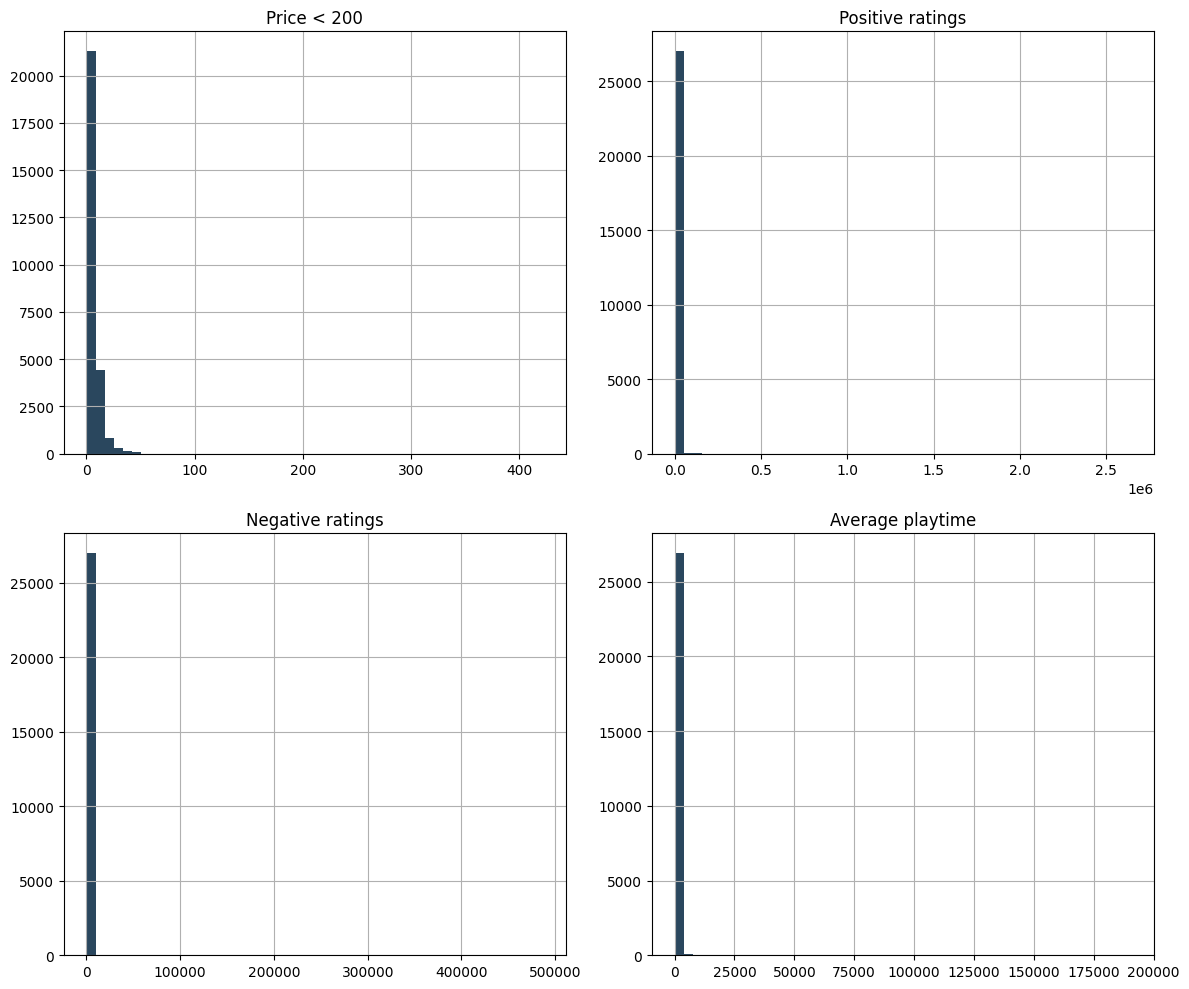

Text(0.5, 1.0, 'Nombre de jeux par année de sortie')

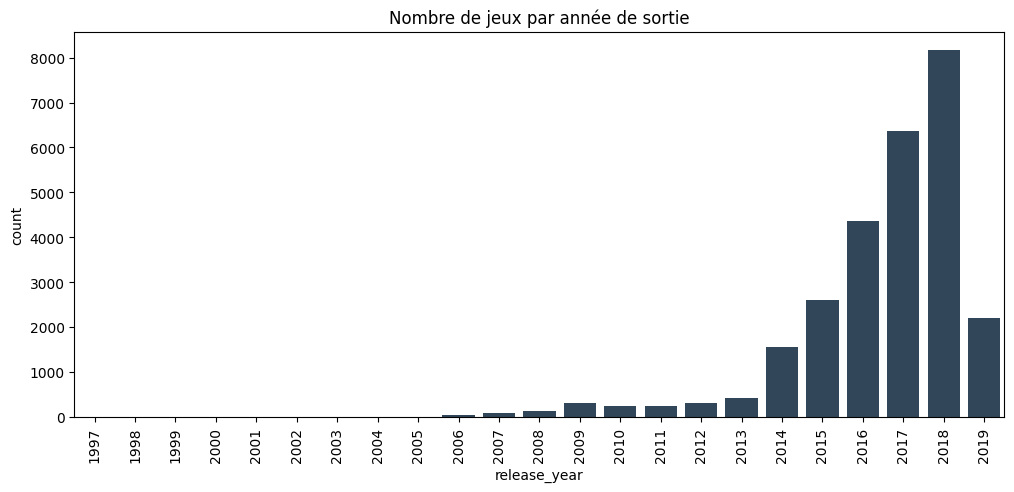

In [82]:
# Histogrammes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogramme price < 200
df['price'].hist(bins=50, ax=axes[0,0], color='#2a475e')
axes[0,0].set_title('Price < 200')

# Histograms pour les autres colonnes
df['positive_ratings'].hist(bins=50, ax=axes[0,1], color='#2a475e')
axes[0,1].set_title('Positive ratings')

df['negative_ratings'].hist(bins=50, ax=axes[1,0], color='#2a475e')
axes[1,0].set_title('Negative ratings')

df['average_playtime'].hist(bins=50, ax=axes[1,1], color='#2a475e')
axes[1,1].set_title('Average playtime')

plt.tight_layout()
plt.show()

# Distribution des années de sortie
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='release_year', color='#2a475e')
plt.xticks(rotation=90)
plt.title('Nombre de jeux par année de sortie')


On observe que pour le prix, le temps de jeu moyen et les évaluations, la grande majorité des jeux présentent des valeurs très faibles, tandis qu'une minorité — parfois seulement quelques titres — affichent des valeurs nettement plus élevées. Cette distribution fortement asymétrique mérite une exploration plus approfondie. Malgré cela, une tendance générale semble se dessiner en ce qui concerne les prix.

Concernant le nombre de jeux sortis par année, on observe une tendance globale à la hausse, avec une nette accélération à partir de 2014. La baisse apparente en 2019 peut s'expliquer par le fait que les données s’arrêtent en cours d’année.

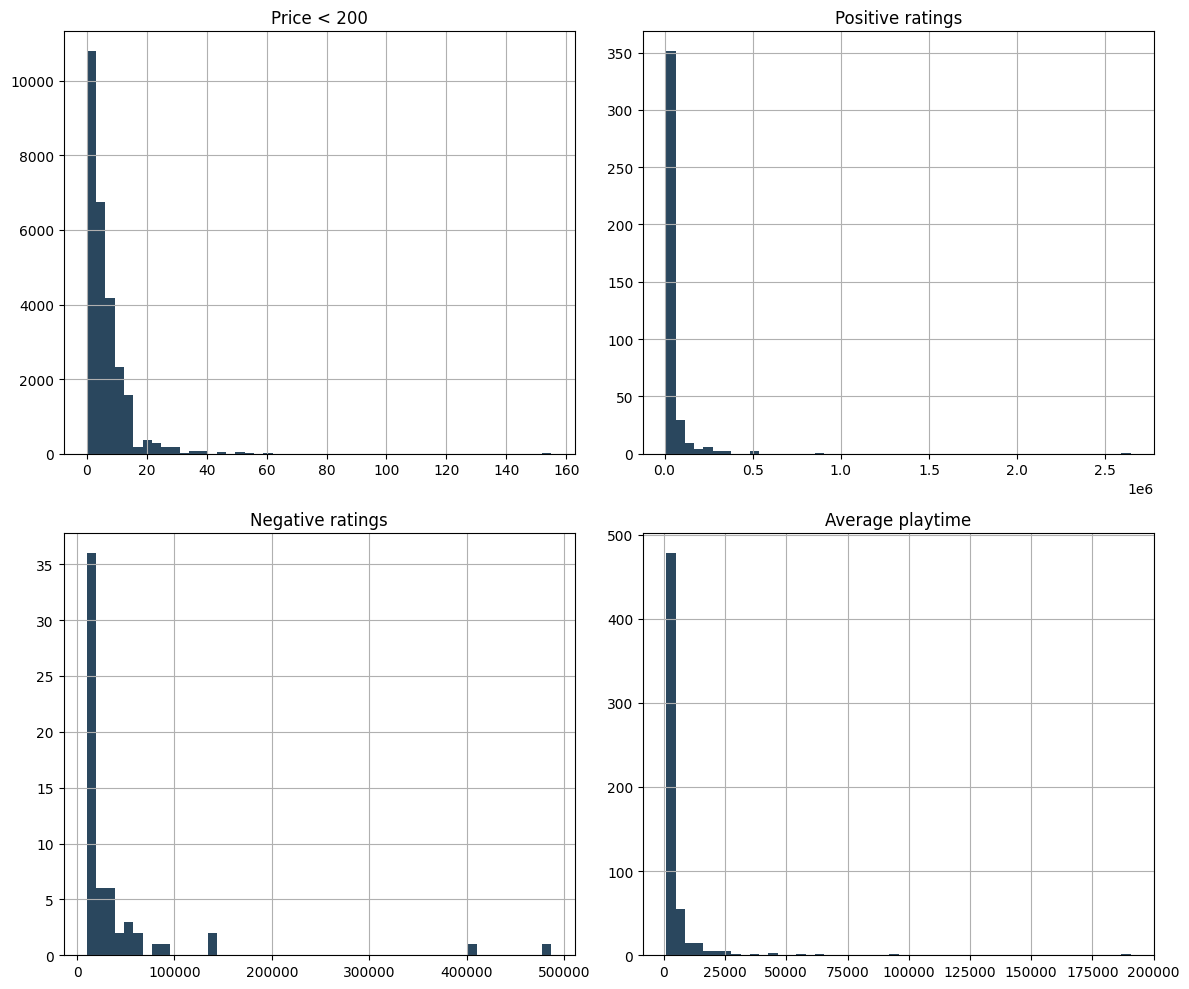

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogramme des prix < 200
df.loc[df['price'] < 200, 'price'].hist(bins=50, ax=axes[0, 0], color='#2a475e')
axes[0, 0].set_title('Price < 200')

# Histogramme des évaluations positives > 10
df.loc[df['positive_ratings'] > 10000, 'positive_ratings'].hist(bins=50, ax=axes[0, 1], color='#2a475e')
axes[0, 1].set_title('Positive ratings')

# Histogramme des évaluations négatives > 10
df.loc[df['negative_ratings'] > 10000, 'negative_ratings'].hist(bins=50, ax=axes[1, 0], color='#2a475e')
axes[1, 0].set_title('Negative ratings')

# Histogramme du temps de jeu moyen
df.loc[df['average_playtime'] > 1000, 'average_playtime'].hist(bins=50, ax=axes[1, 1], color='#2a475e')
axes[1, 1].set_title('Average playtime')

plt.tight_layout()
plt.show()


En fixant des seuils arbitraires et en ne regardant que les jeux à la fois chers, populaires et bien notés, on observe — comme on pouvait s'y attendre — que la majorité des jeux présentent des valeurs faibles sur ces critères, et que leur nombre décroît à mesure que ces valeurs augmentent.

### Analyse bivariée

<Axes: >

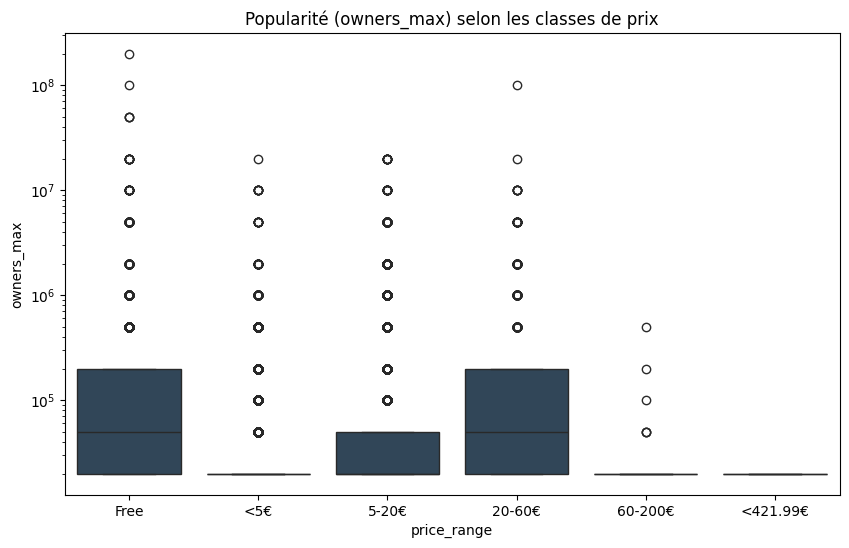

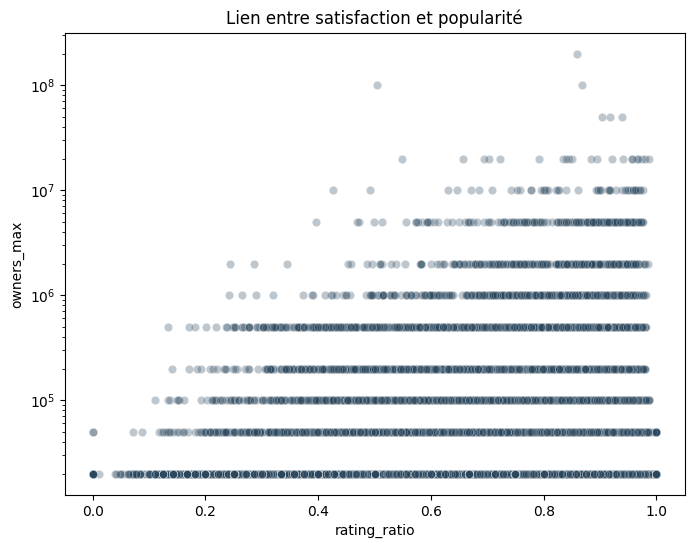

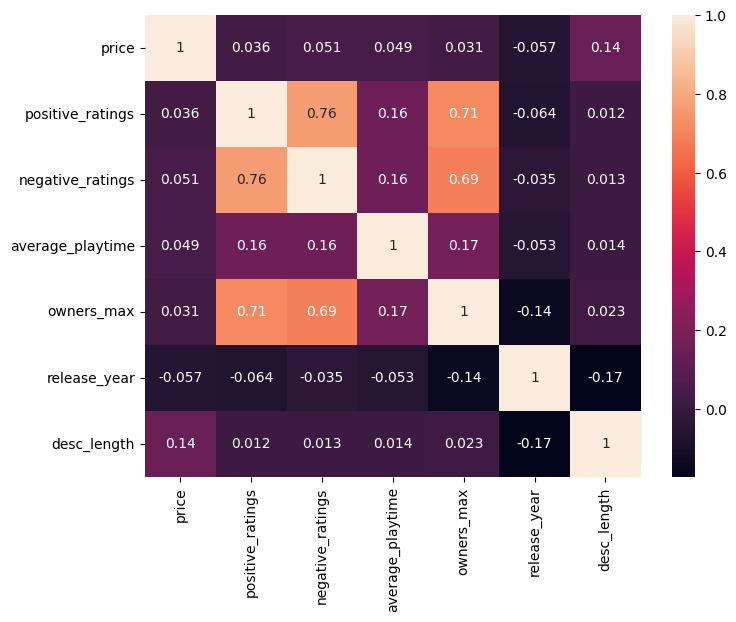

In [84]:
# Boxplot : prix vs popularité
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='price_range', y='owners_max', color='#2a475e')
plt.yscale('log')
plt.title("Popularité (owners_max) selon les classes de prix")

# Scatter : satisfaction vs popularité
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='rating_ratio', y='owners_max', alpha=0.3, color='#2a475e')
plt.yscale('log')
plt.title("Lien entre satisfaction et popularité")

# Corrélations
plt.figure(figsize=(8,6))
sns.heatmap(df[['price', 'positive_ratings', 'negative_ratings', 'average_playtime', 'owners_max', 'release_year', 'desc_length']].corr(), annot=True)

#### Boxplots : Prix vs Popularité

En analysant la popularité en fonction des classes de prix, plusieurs phénomènes intéressants émergent :

- **Deux classes se démarquent positivement** :
    - Les jeux gratuits, accessibles à tous, favorisent un large nombre de téléchargements.
    - Les jeux situés entre 20 € et 60 €, qui correspondent souvent à des blockbusters bénéficiant d'une grande visibilité.

- **Jeux très peu chers** :
    - Même s’ils ne sont pas gratuits, les jeux à prix très bas restent assez populaires grâce à leur accessibilité financière.
    - On retrouve ici beaucoup de jeux indépendants ou casuals.

- **Jeux très chers** :
    - Leur popularité est en moyenne plus faible.
    - Cela peut s’expliquer par une offre plus restreinte dans ces gammes de prix, mais aussi par un positionnement de niche, visant des joueurs très spécifiques (simulateurs, jeux spécialisés, etc.).

---

#### Analyse du scatterplot : Satisfaction vs Popularité

- **Jeux peu populaires** :
    - Très grande dispersion des ratios de satisfaction.
    - Cela montre que certains jeux confidentiels sont très bien notés, d'autres très mal — la qualité ne dépend pas nécessairement de la popularité.

- **Tendance générale** :
    - Plus un jeu est populaire, meilleur est son **ratio de satisfaction**.
    - La variance diminue : les jeux populaires tendent à recevoir des retours plus positifs de manière globale.

- **Cas particulier** :
    - Une **légère baisse du ratio de satisfaction** est visible pour les trois jeux les plus populaires.
    - Cela peut s’expliquer par une très large audience (et donc plus de critiques diverses), ou des effets de hype/déception.

---

#### Analyse des corrélations

##### Prix
- **Corrélations très faibles** (proches de 0) avec presque toutes les variables.
- Seule exception : une **légère corrélation positive avec la longueur de la description** (~0.14).
    - Hypothèse : les jeux plus chers prennent plus de temps à se présenter, avec des descriptions plus détaillées.

##### Notes positives et négatives
- **Forte corrélation entre `positive_ratings` et `negative_ratings`** (0.76).
    - Plus un jeu a de visibilité, plus il récolte d’avis dans les deux sens.

- **Forte corrélation entre `positive_ratings` et `owners_max`** (0.71), et aussi avec `negative_ratings` (~0.69).
    - Popularité entraîne davantage d’engagement (avis positifs et négatifs).

##### Temps de jeu moyen
- **Corrélations faibles à modérées** (~0.15–0.17) avec :
    - Le nombre de joueurs (`owners_max`)
    - Le nombre d’avis
- Cela suggère qu’un temps de jeu moyen plus long est **légèrement** associé à une plus grande popularité.

##### Popularité (`owners_max`)
- Corrélée aux :
    - `positive_ratings` (0.71)
    - `negative_ratings` (0.69)
- **Corrélation négative modérée avec `release_year`** (-0.14) :
    - Les jeux plus anciens tendent à être plus populaires, ayant eu plus de temps pour se diffuser.

##### Année de sortie
- **Corrélations négatives faibles** avec la plupart des variables :
    - Les jeux récents ont **moins de joueurs, moins d’avis, des descriptions plus courtes et des temps de jeu moyens plus faibles**.

##### Longueur de la description
- Corrélations très faibles avec toutes les autres variables.

---

#### Synthèse générale

- **La popularité (`owners_max`)** est fortement liée :
    - À la **quantité d’avis** (positifs et négatifs).
    - À l’**ancienneté du jeu**.

- **Le prix** n’est **quasiment pas corrélé** à la popularité, aux notes, ou au temps de jeu.

- **Les jeux récents** tendent à être :
    - Moins populaires.
    - Moins commentés.
    - Moins détaillés dans leurs fiches.

- **Le temps de jeu moyen** a un **impact très limité** sur les autres variables, mais reste **légèrement positif** en lien avec la popularité.

---


### Analyse des tags

<Axes: title={'center': 'Tags associés à des jeux populaires'}>

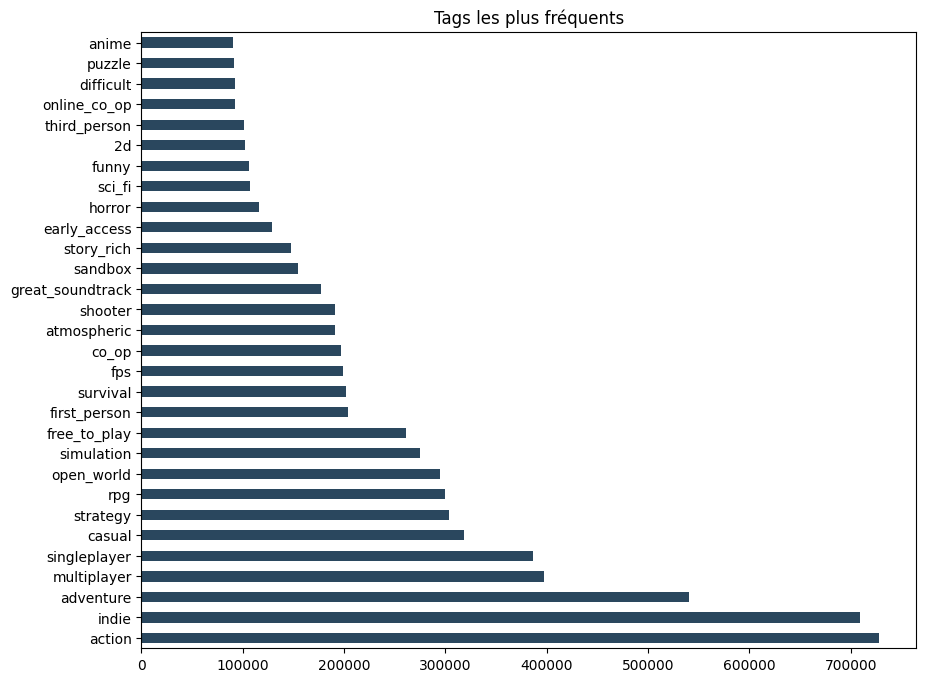

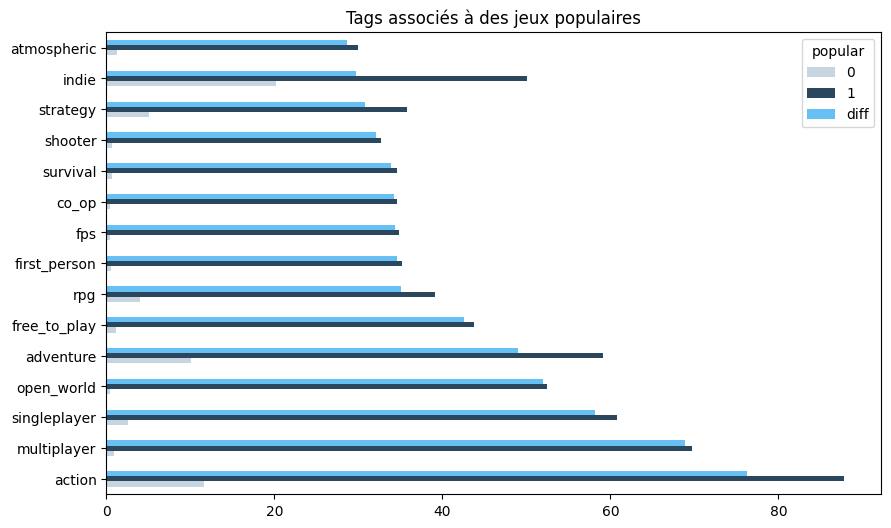

In [85]:
# Extraction des colonnes tags
tag_cols =  df.columns[24:394]

# Top tags utilisés
tag_sums = df[tag_cols].sum().sort_values(ascending=False).head(30)
tag_sums.plot(kind='barh', figsize=(10,8), title="Tags les plus fréquents", color='#2a475e')

# Tags favorables à la popularité
tag_success = df.groupby('popular')[tag_cols].mean().T
tag_success['diff'] = tag_success[1] - tag_success[0]
tag_success.sort_values('diff', ascending=False).head(15).plot(
    kind='barh',
    figsize=(10, 6),
    title="Tags associés à des jeux populaires",
    color=['#c7d5e0', '#2a475e', '#66c0f4']  # bleu (hex), tu peux mettre une couleur différente
)




- Le tag action est le plus répandu (728 416 jeux) : cela signifie que parmi tous les jeux du dataset, environ 728 416 sont identifiés comme jeux d’action, ce qui en fait la catégorie la plus représentée.
- Les tags indie (709 652), adventure (540 123) et multiplayer (397 327) suivent de près. Cela indique que les jeux indépendants et d’aventure sont très nombreux, et que les jeux multijoueurs occupent également une place importante.
- Des tags comme singleplayer (386 511), casual (318 387) ou strategy (303 942) représentent d’autres grandes catégories très présentes dans le dataset.
- On note aussi la présence de tags plus spécifiques ou qualitatifs, tels que great_soundtrack (177 153) ou atmospheric (190 813), qui reflètent davantage des critères d’appréciation ou d’ambiance que des genres stricts.

Cependant il reste des points d’attention :

- Redondances et chevauchements : certains tags peuvent se recouper, par exemple shooter et fps, ou multiplayer et co_op, ce qui peut introduire des doublons dans l’analyse.
- Déséquilibre des tags : certains tags très fréquents peuvent masquer la présence de catégories plus spécifiques ou de niche.

Tags les plus associés à la popularité :

- action, multiplayer, singleplayer, open_world, adventure sont en tête : ce sont clairement des caractéristiques clés des jeux populaires.

- Par exemple, un jeu multijoueur ou avec un mode solo très marqué a plus de chances d’être populaire.

Interprétation générale :

- Les tags liés à l’action et à l’expérience de jeu immersive (open_world, fps, shooter) ont un impact fort.

- Les jeux qui mélangent des modes solo et multijoueur sont largement plus populaires.

- Même le tag free_to_play a une différence positive importante, ce qui montre que certains jeux gratuits sont aussi très populaires.

Limitations :

- Cette analyse montre une corrélation, pas une causalité. Le tag "action" ne cause pas la popularité, mais il est très fréquent dans les jeux populaires.

- Certains tags ont un poids élevé peut-être parce qu’ils sont plus répandus dans des genres très joués.

Pour cela il est interessant de faire une matrice de co-occurence

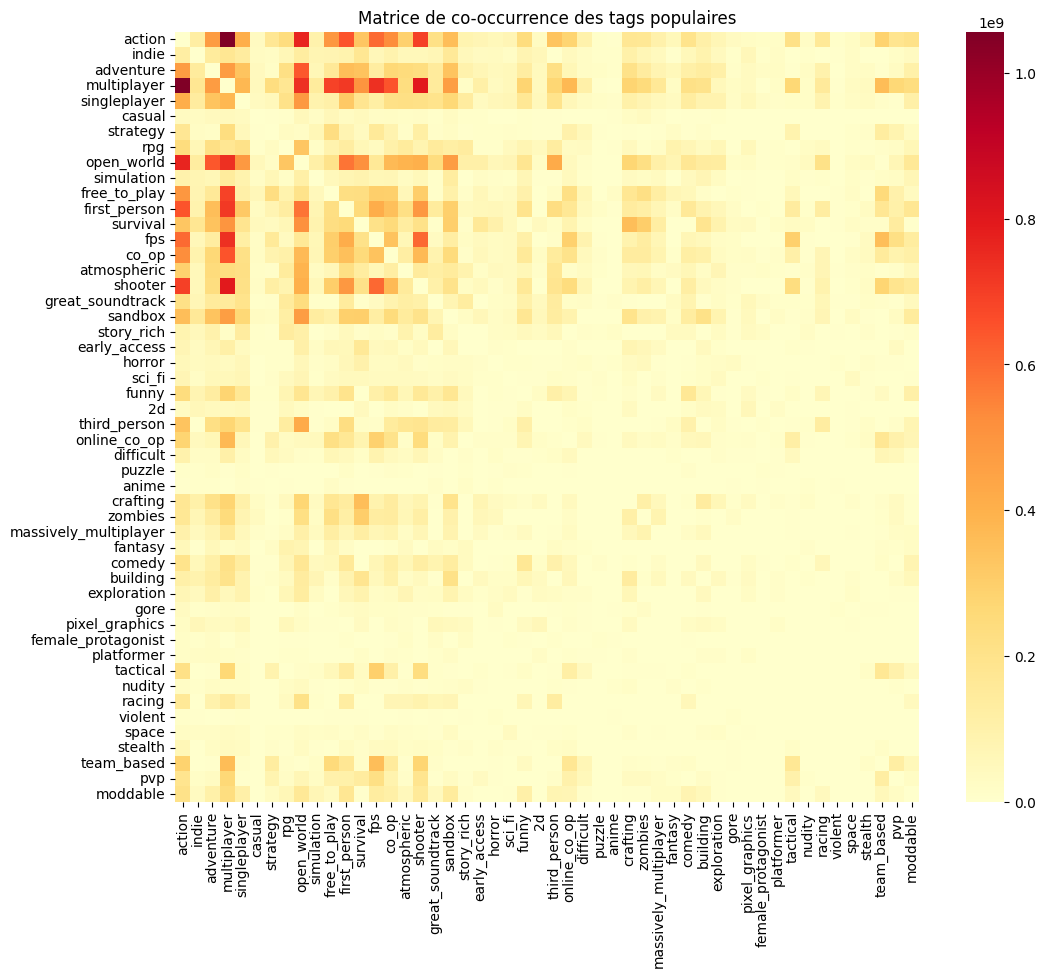

feature_film        0.0
360_video        1925.0
skating          4375.5
bmx              4882.5
hardware         7598.0
cycling         12171.0
atv             13235.0
foreign         14510.0
hockey          17406.0
tennis          24796.5
dtype: float64


In [86]:
tag_sums = df[tag_cols].sum().sort_values(ascending=False).head(50)
# Matrice de co-occurrence (multiplication de la matrice binaire des tags par sa transposée)
tag_matrix = df[tag_cols].astype(int)
co_occurrence = tag_matrix.T.dot(tag_matrix)

# On supprime la diagonale pour éviter la surreprésentation
np.fill_diagonal(co_occurrence.values, 0)

# Affichage d'une heatmap des tags les plus fréquents
top_tags = tag_sums.head(200).index
plt.figure(figsize=(12,10))
sns.heatmap(co_occurrence.loc[top_tags, top_tags], cmap="YlOrRd")
plt.title("Matrice de co-occurrence des tags populaires")
plt.show()

somme_par_colonne = co_occurrence.sum()/2
plus_faibles = somme_par_colonne.nsmallest(10)
print(plus_faibles)

Sur cette matrice de co-occurrence, on observe que certains tags apparaissent fréquemment ensemble sur les mêmes jeux, ce qui révèle des relations fortes entre ces catégories. Par exemple, les tags 'multiplayer' et 'action' coexistent très souvent, ce qui est cohérent car de nombreux jeux d'action proposent un mode multijoueur.

De plus, ces deux tags sont aussi fréquemment associés avec d'autres tags populaires comme 'open_world', 'free_to_play', 'fps', 'co_op' et 'shooter'. Cela indique l'existence d'un groupe de jeux très actifs et compétitifs, souvent en ligne, où ces caractéristiques se combinent pour définir l'expérience utilisateur.

En revanche, certains tags montrent peu de co-occurrences avec les autres, ce qui peut suggérer qu'ils correspondent à des niches spécifiques ou à des caractéristiques plus isolées. Par exemple, 'skating', 'bmx' ou 'hardware' apparaissent rarement associés avec d'autres tags. Cela peut refléter un public ciblé plus restreint ou des jeux très spécialisés.

Enfin, certains tags comme 'feature_film' n'ont aucune co-occurrence, ce qui est logique car ce tag pourrait ne pas être utilisé conjointement avec d'autres dans ce dataset, ou représenter une catégorie totalement distincte.

Cette analyse montre ainsi comment la matrice de co-occurrence permet d'identifier des clusters thématiques dans les jeux, en révélant les combinaisons de tags les plus fréquentes, tout en mettant en lumière des catégories plus marginales ou uniques.


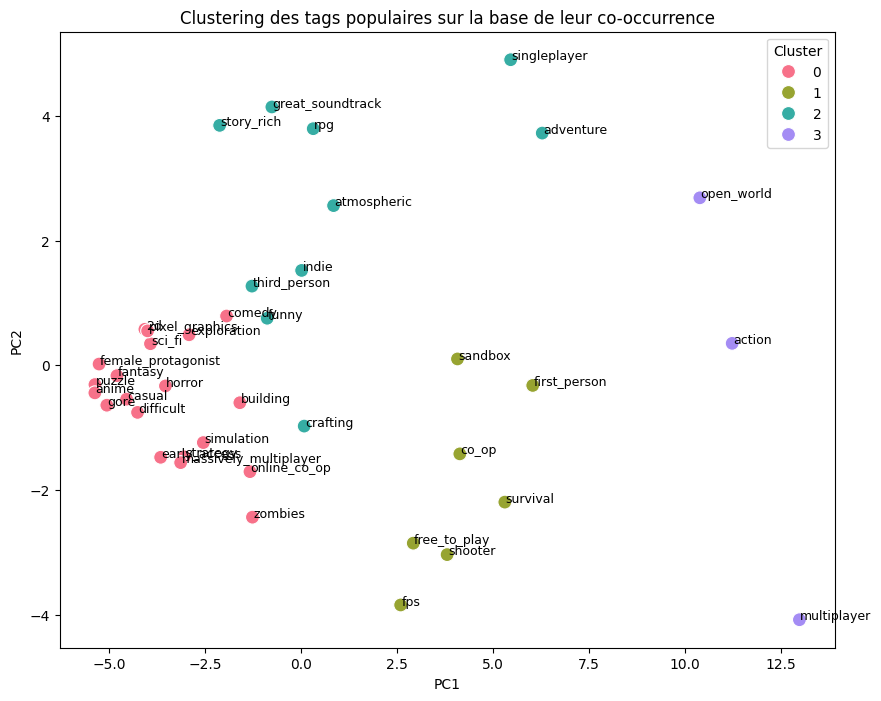

In [87]:
top_tags = tag_sums.head(40).index
co_occ_sub = co_occurrence.loc[top_tags, top_tags]

# Normaliser les données
scaler = StandardScaler()
co_occ_scaled = scaler.fit_transform(co_occ_sub)

# Réduction de dimension à 2 composantes principales
pca = PCA(n_components=2)
co_occ_pca = pca.fit_transform(co_occ_scaled)

# Appliquer un clustering KMeans (par exemple 4 clusters, tu peux ajuster)
k = 4
kmeans = KMeans(n_clusters=k, random_state=4)
clusters = kmeans.fit_predict(co_occ_pca)

# Visualisation
plt.figure(figsize=(10,8))
palette = sns.color_palette("husl", k)
sns.scatterplot(x=co_occ_pca[:,0], y=co_occ_pca[:,1], hue=clusters, palette=palette, s=100)

for i, tag in enumerate(top_tags):
    plt.text(co_occ_pca[i,0]+0.02, co_occ_pca[i,1], tag, fontsize=9)

plt.title("Clustering des tags populaires sur la base de leur co-occurrence")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()


Cluster 0 : Mix “Casual à stratégique” avec ambiance et diversité narrative

- Beaucoup de diversité : stratégie, simulation, casual mais aussi des univers très thématiques (horror, sci-fi, fantasy, zombies, gore).

- Mélange de styles 2D, pixel art, narratives (female protagonist, comedy) et challenge (difficult, puzzle).

- Jeux souvent avec modes en ligne ou coop (massively multiplayer, online_co_op).

- Beaucoup peuvent être expérimentaux ou en développement (early_access).

- Ces jeux attirent probablement une communauté large et passionnée par la profondeur, l’exploration, et les expériences narratives ou esthétiques marquées.

Cluster 1 : FPS & survie multijoueur, ambiance “core gamer” / compétitive

- Regroupe surtout les jeux d’action à la première personne (FPS), tir et survie.

- Orientation souvent multijoueur/co-op dans un monde sandbox.

- Free-to-play indique des modèles économiques souvent compétitifs et communautaires (ex : battle royale, jeux de tir populaires).

- Cluster clairement centré sur des joueurs qui cherchent du challenge, de l’action rapide et de la coopération tactique.

Cluster 2 : Jeux “Indie aventure narrative et RPG”

- Ce sont des jeux souvent solo, orientés aventure et RPG avec une forte ambiance.

- Mise en avant de la narration (story_rich), de l’atmosphère et de la musique (great_soundtrack).

- Style souvent indie, plus artistique et expérimental.

- Inclut aussi du crafting, gameplay souvent profond et exploration immersive.

- Cluster typique des jeux qui misent sur l’expérience émotionnelle et la créativité plus que sur la compétition ou l’action pure.

Cluster 3 : Action multijoueur et open world

- Cluster plus simple, mais très cohérent.

- Regroupe les jeux orientés action avec des mondes ouverts, souvent en multijoueur.

- Ce sont probablement des jeux AAA, avec de grands mondes à explorer, souvent très populaires.

- Le cœur du gameplay est dynamique, compétitif ou coopératif, mais avec une liberté d’exploration importante.

### Analyse des développeurs

Je vais commencer par analyser les développeurs les plus actifs et leur popularité

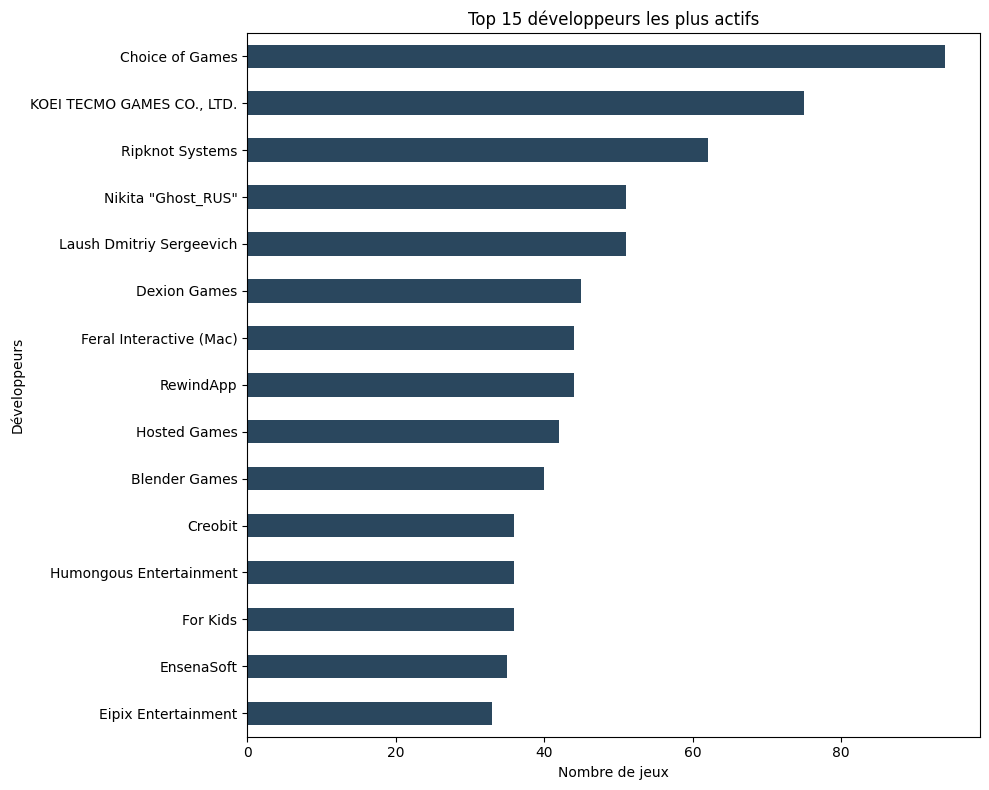

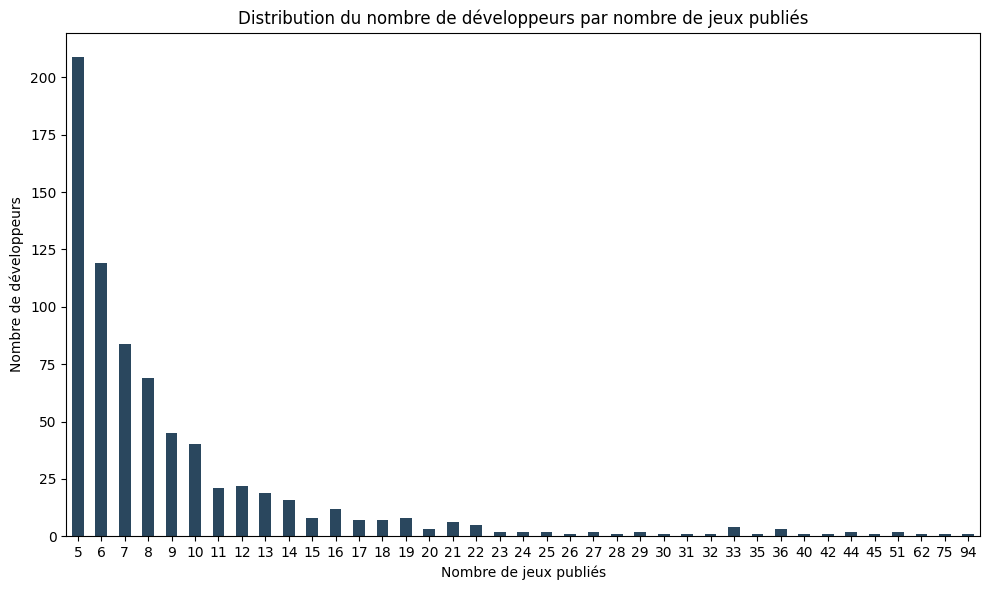

In [88]:
# 1. Explosion de la colonne liste : une ligne par développeur
df_exploded = df.explode('developer_list')

# 2. Compte du nombre de jeux par développeur
top_devs = df_exploded['developer_list'].value_counts()

# === Graphique 1 : Top 15 développeurs les plus actifs ===
plt.figure(figsize=(10, 8))
top_devs.head(15).plot(kind='barh', color='#2a475e')
plt.title("Top 15 développeurs les plus actifs")
plt.xlabel("Nombre de jeux")
plt.ylabel("Développeurs")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# === Graphique 2 : Distribution nombre de jeux / nombre de développeurs ===
games_per_dev = df_exploded['developer_list'].value_counts()

# Compte combien de développeurs ont publié n jeux
dev_count_by_game_number = games_per_dev.value_counts().sort_index()
dev_count_by_game_number = dev_count_by_game_number[dev_count_by_game_number.index >= 5]

plt.figure(figsize=(10, 6))
dev_count_by_game_number.plot(kind='bar', color='#2a475e')
plt.title("Distribution du nombre de développeurs par nombre de jeux publiés")
plt.xlabel("Nombre de jeux publiés")
plt.ylabel("Nombre de développeurs")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


On observe qu’un nombre restreint de développeurs se démarque nettement en ayant publié plus de 40 jeux. Une seconde catégorie regroupe des studios actifs, comptant entre 15 et 40 titres, tandis que la grande majorité des développeurs n’ont publié que quelques jeux, souvent moins de 15.

Cette distribution suggère une concentration de la production autour de quelques studios très prolifiques, alors qu’une grande partie de l’offre sur Steam provient de petits studios ou d’indépendants aux catalogues plus modestes.

<Axes: title={'center': 'Studios avec jeux populaires (moyenne > 100k owners)'}, ylabel='Développeurs'>

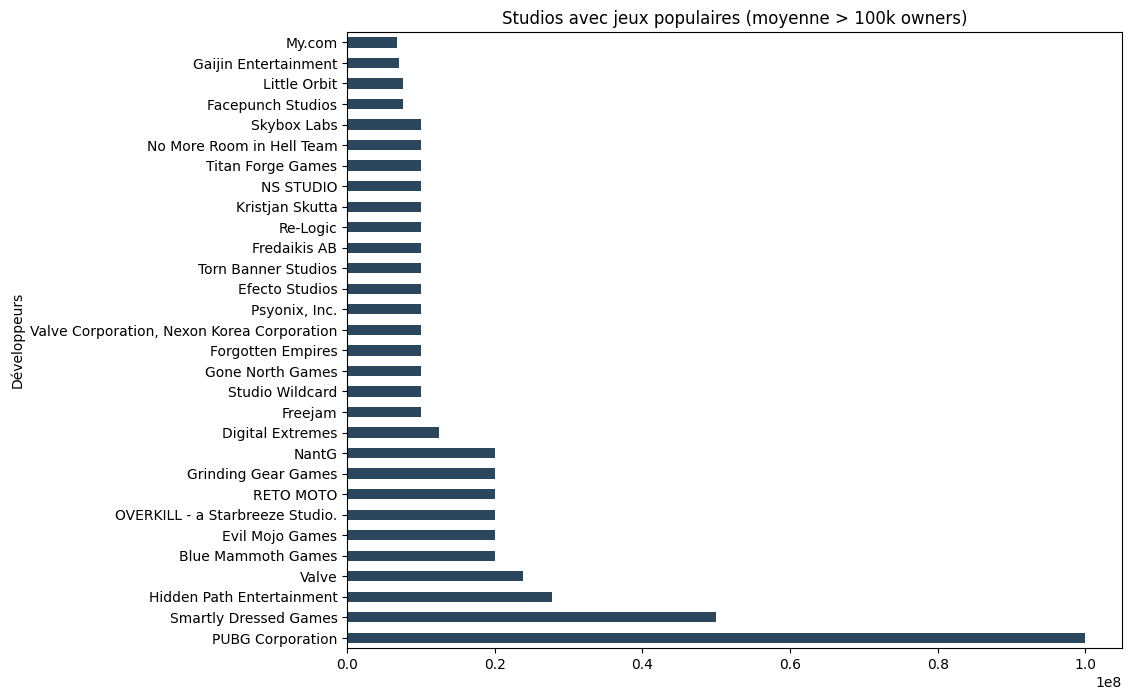

In [89]:
# Exploser pour avoir une ligne par développeur individuel
df_exploded = df.explode('developer_list')

# Nettoyer les espaces si besoin
df_exploded['developer_list'] = df_exploded['developer_list'].str.strip()

# Calculer la moyenne d'owners_max par développeur
popular_devs = df_exploded.groupby('developer_list')['owners_max'].mean().sort_values(ascending=False)

# 5. Visualisation
popular_devs.head(30).plot(
    kind='barh',
    figsize=(10, 8),
    title="Studios avec jeux populaires (moyenne > 100k owners)",
    color='#2a475e', 
    ylabel="Développeurs"
    )

Ce que ces chiffres montrent :

- Ce tableau classe les 30 studios de jeux vidéo ayant les jeux les plus populaires (en moyenne), selon le nombre estimé de joueurs possédant ces jeux sur Steam (owners_max).

- PUBG Corporation est largement en tête, avec un jeu dépassant les 100 millions de joueurs.

- Des noms bien connus comme Valve/Valve Corporation (créateur de Half-Life, CS:GO, Dota) apparaissent aussi en haut de classement.

- D'autres comme Psyonix (créateur de Rocket League) ou Re-Logic (Terraria) confirment leur succès planétaire.

Ce qu'on peut en conclure simplement :

- Les studios listés ici ont souvent publié un ou deux énormes succès, plus que des dizaines de petits jeux.

- Beaucoup de ces jeux sont free-to-play ou massivement multijoueur, ce qui attire plus de joueurs.

- Certains noms sont peu connus du grand public, mais ont percé avec un seul hit viral (Kristjan Skutta, Gone North Games...).

Analyse technique et approfondie :

1. PUBG Corporation en tête : un one-hit wonder

- PUBG (PlayerUnknown’s Battlegrounds) a explosé le marché du Battle Royale bien avant Fortnite sur Steam.

- Le fait qu’ils aient qu’un seul jeu dans ton dataset explique cette moyenne énorme (1 jeu = 100M → moyenne = 100M).

- Il faut donc nuancer : on mesure ici des moyennes, pas un volume total de jeux.

2. 🕹 Valve : valeur sûre avec plusieurs hits

- Valve est ici représenté deux fois : Valve et Valve Corporation, Nexon Korea Corporation (co-développement de Counter-Strike Online en Asie)

- Leurs jeux (CS:GO, Dota 2, TF2) sont gratuits et très populaires, ce qui biaisent positivement la métrique owners_max.

- Ils sont aussi les créateur de plateforme Steam elle-même, ce qui renforce leur exposition.

3. 🎮 Petits développeurs, gros coups

- Kristjan Skutta : développeur solo du jeu Unturned, un jeu de survie gratuit ayant explosé grâce à son gameplay simple et à la communauté YouTube/Twitch.

- Gone North Games : développeur de A Story About My Uncle, un jeu d’aventure narratif qui a eu un petit succès critique.

- Ces exemples montrent que la viralité peut battre le budget : certains développeurs inconnus dépassent des géants grâce à la communauté.

Biais à connaître dans cette métrique :

- En regardant une moyenne, un seul jeu ultra-populaire gonfle le résultat (exemple de PUBG).

- Les studios qui font beaucoup de jeux modestes apparaîtront moins, même s’ils ont de la qualité.

- Les données sont estimatées, Steam ne donne pas officiellement les chiffres du nombre de personnes possédant un jeu (ici on utilise des intervalles).


Il peut donc être interessant d'analyser le taux de satisfaction par développeur :

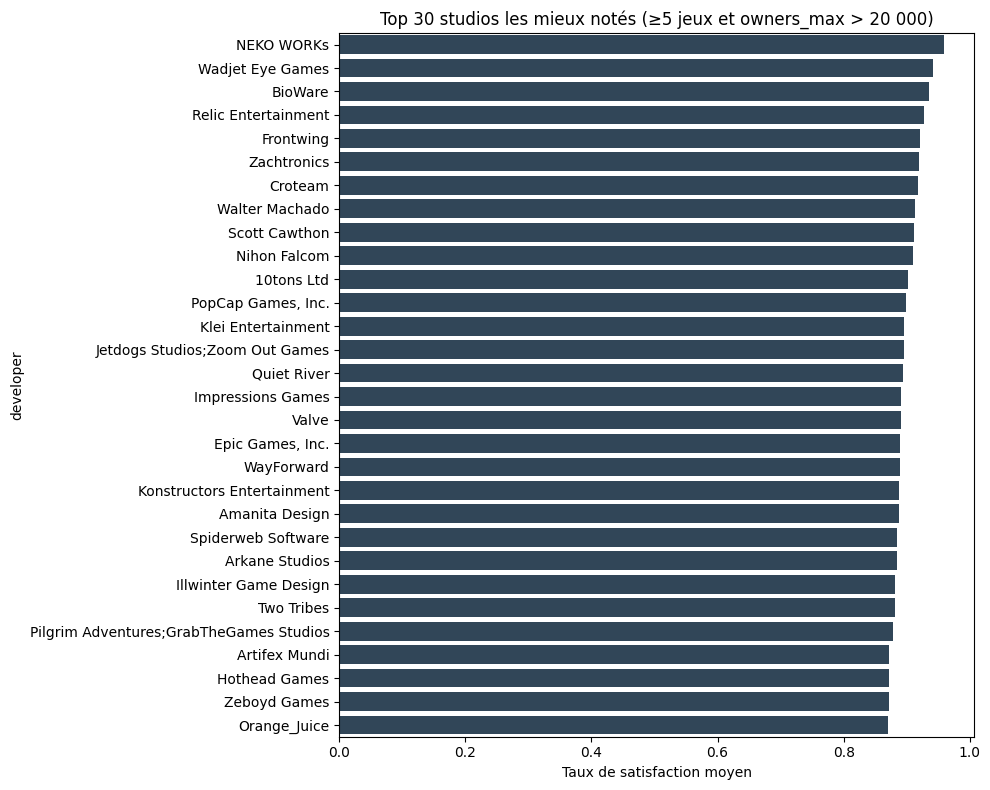

,n_games,avg_rating
developer,,
NEKO WORKs,6,0.958419
Wadjet Eye Games,7,0.940896
BioWare,5,0.934578
Relic Entertainment,8,0.926919
Frontwing,5,0.920568
Zachtronics,7,0.918965
Croteam,5,0.917025
Walter Machado,6,0.912987
Scott Cawthon,8,0.911100


In [90]:
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # Par défaut, bonne couverture

# Filtrer les jeux
df_filtered = df[df['owners_max'] > 20000]

# Moyenne de rating_ratio (satisfaction) par développeur avec au moins 5 jeux (parmi les jeux populaires)
dev_ratings = df_filtered.groupby('developer').agg(
    n_games=('steam_appid', 'count'),
    avg_rating=('rating_ratio', 'mean')
)

# 🔎 Garder les développeurs avec au moins 5 jeux
dev_ratings_filtered = dev_ratings[dev_ratings['n_games'] >= 5].sort_values('avg_rating', ascending=False).head(30)

# Visualisation
plt.figure(figsize=(10, 8))
sns.barplot(data=dev_ratings_filtered, x='avg_rating', y=dev_ratings_filtered.index, color='#2a475e')
plt.xlabel("Taux de satisfaction moyen")
plt.title("Top 30 studios les mieux notés (≥5 jeux et owners_max > 20 000)")
plt.tight_layout()
plt.show()

# Affichage du DataFrame final
dev_ratings_filtered


Les résultats révèlent :
1. Studios très appréciés, même s’ils ne sont pas ultra-mainstream

NEKO WORKs (avg rating ≈ 95.8 %) :

- Studio japonais connu pour la série Nekopara (visual novel très populaire).

- Petites productions, mais très bien accueillies par leur public ciblé.

- Leur excellent score montre une niche fidèle et satisfaite.

Wadjet Eye Games (~94 %) :

- Spécialistes de point-and-click narratifs (ex : Blackwell, Unavowed).

- Très respectés dans le milieu indé : peu de jeux, mais très qualitatifs.

    Zachtronics (~91.9 %) :

- Réputé pour ses jeux de programmation/logique (Opus Magnum, TIS-100).

- Touche un public de joueurs "experts", très fidèles.

Ces studios sont des exemples d’excellence dans leur niche, avec des taux de satisfaction très élevés malgré des tailles modestes.

2. Studios plus classiques / AAA bien classés aussi

BioWare (~93.5 %) :

- Mass Effect, Dragon Age… malgré quelques controverses récentes, leur "legacy" reste fort.

Relic Entertainment (~92.7 %) :

- Company of Heroes, Dawn of War → excellents jeux de stratégie, communauté passionnée.

Valve (~89.1 %) :

- Avec 26 jeux passés le filtre des 20 000 owners, c’est le plus prolifique du top 30.

- Malgré la diversité, la moyenne reste très élevée, preuve d’une qualité constante.

Arkane Studios (~88.4 %) :

- Dishonored, Prey… des jeux innovants salués pour leur gameplay et level design.

Leur présence valide que certaines grandes entreprises peuvent maintenir une qualité élevée malgré la pression commerciale et les volumes de production.


3. Studios indépendants ou atypiques

Scott Cawthon (~91.1 %) : Créateur de Five Nights at Freddy’s → très clivant, mais adoré par sa communauté.

Amanita Design (~88.8 %) : Machinarium, Samorost… direction artistique unique, excellente immersion sonore/graphique.

Spiderweb Software (~88.5 %) : Très anciens RPG old-school, très bien notés malgré des graphismes simples.

Ces studios montrent que l’originalité paie : si le jeu a une personnalité forte et un public clair, il peut obtenir des scores de satisfaction excellents.


Une analyse du rating_ratio moyen par développeur, filtrée sur les jeux ayant au moins 20 000 utilisateurs estimés, révèle une surreprésentation de studios indépendants et spécialisés. Leur capacité à satisfaire une base d’utilisateurs ciblée semble les avantager par rapport à des studios plus généralistes. Néanmoins, certains géants comme Valve, BioWare ou Relic maintiennent un excellent niveau de satisfaction tout en publiant de nombreux titres

Prix moyen des jeux par studio :

,n_games,avg_price
developer,,
KT Racing,5,34.990000
FIRST_UKRAINIAN,5,31.630000
Croteam VR,5,30.190000
"KOEI TECMO GAMES CO., LTD.",72,28.014028
"Spike Chunsoft Co., Ltd.",10,27.900000
ARTDINK,9,26.990000
Tamsoft,6,26.823333
Codemasters,6,26.490000
HB Studios,5,23.290000


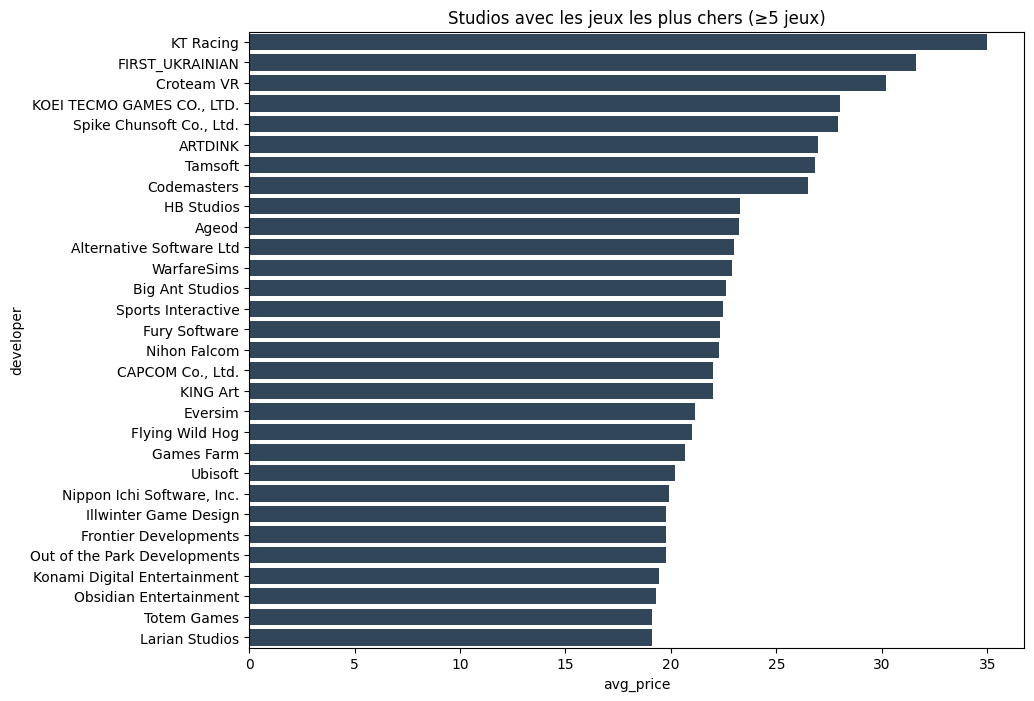

In [91]:
# Prix moyen par développeur (filtrés pour au moins 5 jeux)
dev_prices = df.groupby('developer').agg(
    n_games=('steam_appid', 'count'),
    avg_price=('price', 'mean')
)
dev_prices_filtered = dev_prices[dev_prices['n_games'] >= 5].sort_values('avg_price', ascending=False).head(30)


plt.figure(figsize=(10, 8))
sns.barplot(data=dev_prices_filtered, x='avg_price', y=dev_prices_filtered.index, color='#2a475e')
plt.title("Studios avec les jeux les plus chers (≥5 jeux)")

dev_prices_filtered


On remarque :

- KT Racing publie les jeux les plus cher, ce qui correspond à leur positionnement sur des jeux de course automobile réalistes (ex : WRC series).

- Croteam VR vend des versions VR de leurs titres, souvent à prix fort.

- KOEI TECMO est un cas intéressant : avec 72 jeux, ils arrivent à garder un prix moyen élevé → probablement dû à des licences d'anime populaires (Attack on Titan, Dynasty Warriors, etc.).

Il y a aussi des studios spécialisés dans des niches premium :

- Plusieurs développeurs comme  WarfareSims, Ageod, Eversim, ou Fury Software proposent des jeux de stratégie militaire/complexe, généralement peu grand public, mais à fort ticket d’entrée.

- Ces studios visent un public de niche passionné qui accepte de payer plus cher pour de la profondeur et de la rejouabilité.

Les "gros" développeurs généralistes : Ubisoft,  CAPCOM, Konami, Larian Studios, Obsidian Entertainment

- Ces studios publient souvent des AAA avec des promotions régulières, ce qui réduit leur moyenne.

- Ils restent quand même au-dessus de 19€, ce qui montre qu’ils valorisent leurs titres, même après quelques années.

- Larian propose des RPG profonds (Divinity, Baldur’s Gate) — bon équilibre entre qualité et prix moyen.


Il y a des écosystèmes bien distincts : niche exigeante, VR, AAA classique, etc.
Certains studios comme KOEI TECMO, Spike Chunsoft ou CAPCOM maintiennent des prix élevés malgré un grand nombre de titres.
Les studios indés ou de stratégie peuvent vendre peu, mais cher — leur survie dépend de quelques fans fidèles.

## Prédiction

**Objectif** : prédire si un jeu sera populaire ou non, basé sur ses caractéristiques.

Division du jeu de données en train/test (80/20)

- Tester 2-3 modèles simples :
    RandomForest, LogisticRegression, GradientBoosting, éventuellement XGBoost

- Évaluer via :

    - accuracy, recall, precision, f1-score

    - matrice de confusion

    - importance des features

### Random Forest

Pour prédire si un jeu vidéo sera populaire ou non, j’ai opté pour un modèle Random Forest, bien adapté à la classification binaire et à la gestion de nombreuses variables catégorielles comme les tags.

Le choix des variables repose sur deux critères principaux :

- **Le réalisme prédictif** : seules les informations disponibles avant ou au moment de la sortie du jeu ont été conservées.

- **La pertinence métier** : les variables choisies sont directement liées à des facteurs qui influencent la popularité potentielle d’un jeu.

J’ai ainsi sélectionné :

- **Le prix** : il influence directement la décision d’achat et peut jouer sur la diffusion du jeu.

- **L’année de sortie* : elle permet de capter des tendances générales du marché ou l’évolution des attentes des joueurs.

- **Les tags** : ils décrivent le contenu, le gameplay et l’ambiance du jeu. Ce sont des indicateurs très utiles pour anticiper l’intérêt d’un public ciblé.

À l’inverse, des variables comme les notes ou le nombre d’évaluations ont été exclues volontairement : bien qu’elles soient corrélées à la popularité, elles ne sont disponibles qu’après la sortie du jeu. Les inclure aurait conduit à un biais temporel et à un modèle irréaliste pour de la prédiction.

[[4208  123]
 [ 360  724]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      4331
           1       0.85      0.67      0.75      1084

    accuracy                           0.91      5415
   macro avg       0.89      0.82      0.85      5415
weighted avg       0.91      0.91      0.91      5415



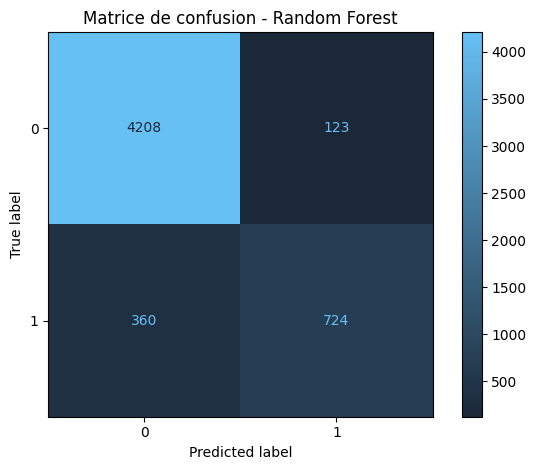

In [92]:
features = ['price', 'release_year'] + list(tag_cols)

X = df[features].dropna()
y = df.loc[X.index, 'popular']  # cible binaire

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

custom_cmap = LinearSegmentedColormap.from_list("steam_blue", ["#1b2838", "#66c0f4"])

# 2. Créer la matrice de confusion
disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=custom_cmap)

plt.title("Matrice de confusion - Random Forest")
plt.tight_layout()
plt.show()

Accuracy:

- Proportion globale de bonnes prédictions : ≈ 91%, c’est un bon score global.

Recall (Sensibilité) — classe "Populaire" :

- Capacité à détecter les vrais jeux populaires : ≈ 67%, donc le modèle en rate environ 33%. Il est prudent, mais pas trop risqué.

Precision — classe "Populaire" :

- Proportion des jeux prédits comme populaires qui le sont vraiment : ≈ 85%, très bon. Quand il dit qu’un jeu est populaire, il a souvent raison.

Recall — classe "Non Populaire" :

- Il est excellente pour détecter les jeux non populaires.

Le f1 score est donc de 0.75, acceptable mais améliorable


Points positifs :

- Le modèle atteint une très bonne précision sur les jeux populaires : lorsqu’il prédit qu’un jeu est populaire, il a raison dans la grande majorité des cas.

- Il affiche un excellent score global, avec plus de 90 % de bonnes prédictions.

- Le modèle est interprétable grâce à l’attribut feature_importances_, qui permet de comprendre quelles variables influencent le plus les décisions.

Points à améliorer :

- Il rate environ un tiers des jeux populaires, ce qui indique un recall perfectible sur cette classe. Cela peut poser problème si l’objectif est de détecter tous les jeux prometteurs.

- Un meilleur équilibre précision / rappel pourrait être recherché, notamment en ajustant le seuil de prédiction ou en testant d'autres modèles.

Je vais étudiez le comportement du modèle selon le seuil pui l'ajuster pour avoir le meilleur modèle possible :

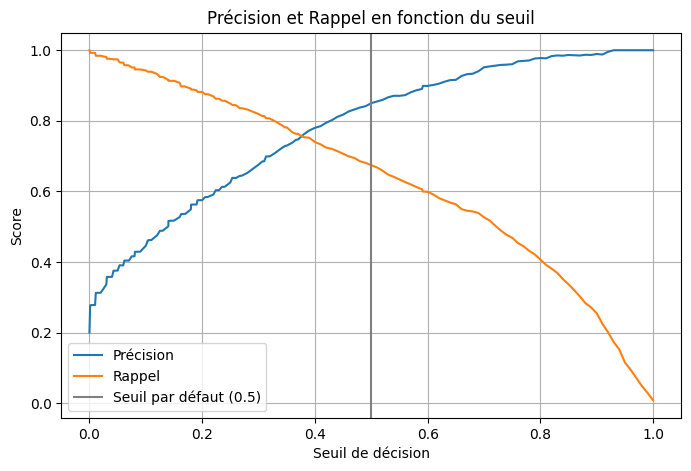

In [93]:
# Probabilité d'appartenance à la classe populaire (1)
y_proba = model.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions[:-1], label="Précision")
plt.plot(thresholds, recalls[:-1], label="Rappel")
plt.axvline(0.5, color='gray', label='Seuil par défaut (0.5)')
plt.xlabel("Seuil de décision")
plt.ylabel("Score")
plt.title("Précision et Rappel en fonction du seuil")
plt.legend()
plt.grid()
plt.show()


In [94]:
# Probabilités de prédire populaire
y_proba = model.predict_proba(X_test)[:, 1]

# Précision, rappel et seuils
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Calcul du F1-score
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Trouver l'indice du F1 max
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"🌟 Meilleur seuil pour F1-score : {best_threshold:.2f}")
print(f"🔢 F1-score correspondant : {best_f1:.3f}")


🌟 Meilleur seuil pour F1-score : 0.39
🔢 F1-score correspondant : 0.762


[[4051  280]
 [ 257  827]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4331
           1       0.75      0.76      0.75      1084

    accuracy                           0.90      5415
   macro avg       0.84      0.85      0.85      5415
weighted avg       0.90      0.90      0.90      5415



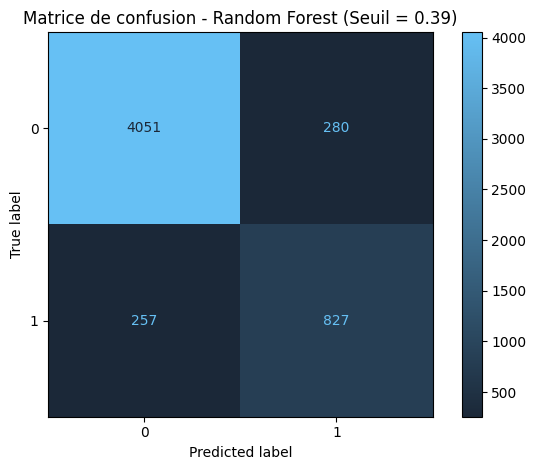

In [95]:
# Choix d'un nouveau seuil 
threshold = 0.37

# Obtenir les probabilités pour la classe 1 (populaire)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred_thresh = (y_proba >= threshold).astype(int)


# Afficher les métriques
print(confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh))

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_thresh),
                              display_labels=model.classes_)
disp.plot(cmap=custom_cmap)
plt.title(f"Matrice de confusion - Random Forest (Seuil = {best_threshold})")
plt.tight_layout()
plt.show()


**Analyse des résultats après optimisation du seuil**

| Classe             | Précision | Rappel (Recall) | F1-score | Support (Nombre d’exemples) |
|--------------------|-----------|-----------------|----------|-----------------------------|
| Non populaire (0)  | 0.94      | 0.94            | 0.94     | 4331                        |
| Populaire (1)      | 0.75      | 0.76            | 0.75     | 1084                        |

- **Accuracy globale** : 90%
- **Macro avg** (moyenne simple) : précision 84%, rappel 85%, F1 85%
- **Weighted avg** (pondérée par support) : précision 91%, rappel 91%, F1 91%

---

- Très bonne précision et rappel sur la classe majoritaire (jeux non populaires) :  
  Le modèle détecte correctement 94% des jeux non populaires, avec peu de fausses alertes.

- Amélioration notable sur la classe des jeux populaires :  
  - Le rappel est passé de ~67% à 76%, ce qui signifie que le modèle rate désormais moins de jeux populaires.  
  - La précision sur les jeux populaires reste solide à 75%, donc quand il prédit un jeu populaire, il a une bonne fiabilité.

- Compromis entre rappel et précision :  
  - Optimiser le seuil a permis d’augmenter la détection des jeux populaires au prix d’un peu plus de faux positifs.  
  - Ce compromis est souvent souhaitable pour ne pas manquer trop de vrais jeux populaires.

- Performance équilibrée et robuste :  
  L’accuracy globale est stable (~90%) mais la performance sur la classe minoritaire, souvent la plus importante, s’est améliorée.

---

**En résumé**

Grâce à l’optimisation du seuil de décision, le modèle améliore sa capacité à repérer les jeux populaires (classe minoritaire) tout en conservant une bonne fiabilité sur les jeux non populaires. Ce résultat est très satisfaisant et montre que le modèle est prêt à être exploité pour des prédictions fiables, avec un bon équilibre entre faux positifs et faux négatifs.


Vérifions les paramètres les plus impactants :

<Axes: title={'center': 'Top 20 features importantes'}>

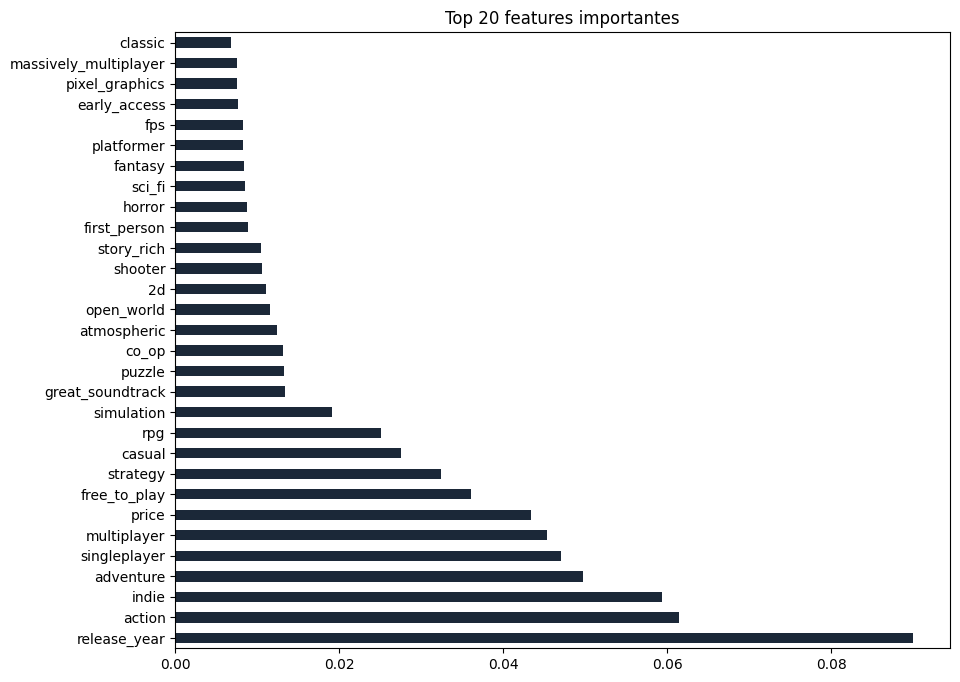

In [96]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(30).plot(kind='barh', figsize=(10,8), title="Top 20 features importantes", color = "#1b2838")

Grâce à l’algorithme de Random Forest, nous identifions les variables les plus explicatives :

- L’année de sortie (release_year) suggère un effet de tendance ou d’évolution du marché.

- Le genre (action, indie, adventure, rpg, etc.) est un critère déterminant : certains types de jeux sont intrinsèquement plus populaires.

- Le type de gameplay (singleplayer, multiplayer, co_op) influence fortement l’engagement.

- Le prix (price) et le modèle économique (free_to_play : accessibilité gratuite mais avantages payants en jeu) pèsent également beaucoup, confirmant que l’accessibilité joue un rôle majeur dans la diffusion.

Ces résultats sont cohérents avec l’exploration initiale du dataset, et renforcent l’idée qu’un jeu récent, accessible, et bien ancré dans les genres populaires a plus de chances de devenir un succès sur Steam.

In [97]:
models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'GradBoost': GradientBoostingClassifier(),
    'MLP': MLPClassifier(max_iter=300)
}

for name, clf in models.items():
    score = cross_val_score(clf, X, y, cv=5, scoring='f1').mean()
    print(f"{name} F1 score: {score:.3f}")


c:\Users\Corentin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Corentin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    htt

LogReg F1 score: 0.640
GradBoost F1 score: 0.522
MLP F1 score: 0.636


### Comparaison des modèles de classification

Afin de prédire la popularité d’un jeu sur Steam, plusieurs modèles de classification ont été testés. Le **F1 score** a été choisi comme métrique principale car il permet de trouver un bon équilibre entre **précision** et **rappel**, ce qui est crucial dans un contexte potentiellement déséquilibré.

#### Résultats obtenus

| Modèle                   | F1 Score |
|--------------------------|----------|
| Random Forest            | 0.762    |
| Réseau de neurones (MLP) | 0.646    |
| Régression Logistique    | 0.640    |
| Gradient Boosting        | 0.523    |

#### Interprétation

- **Random Forest** obtient le meilleur score, avec un **F1 de 0.75**, confirmant sa robustesse face à des données riches et bruitées, comme les tags et genres multiples.
- Le **MLPClassifier** et la **régression logistique** offrent des résultats similaires (~0.64), servant de bons modèles de référence.
- Le **Gradient Boosting** performe étonnamment moins bien (**0.52**), ce qui peut s'expliquer par :
  - un besoin plus fin de réglage des hyperparamètres,
  - une sensibilité plus forte au préprocessing (scaling, outliers, etc.).

---

#### Conclusion

La **Random Forest** est retenue comme **modèle final** pour ce projet. Elle allie :
- une **bonne performance** globale,
- une **interprétabilité facilitée** (notamment via l'analyse des features importantes),
- une relative **stabilité** sans tuning complexe.

Ce modèle sera utilisé pour approfondir l’analyse et dégager des **facteurs déterminants de la popularité** d’un jeu vidéo sur la plateforme Steam.

---


## Conclusion Générale du Projet

**Objectif** :  
Ce projet visait à prédire si un jeu vidéo serait **populaire** sur Steam à partir de ses métadonnées (genre, prix, type de gameplay, date de sortie, etc.). L’enjeu était d’identifier les facteurs clés de succès et de proposer un modèle robuste pour anticiper la réception d’un jeu par les utilisateurs.

---

**Démarche** :
1. **Nettoyage et préparation des données** :
   - Traitement des valeurs manquantes, encodage des tags, normalisation.
   - Gestion de plus de 400 variables (genres, fonctionnalités, prix, etc.).

2. **Analyse exploratoire** :
   - Étude des corrélations, des distributions, et des tendances temporelles.
   - Mise en évidence de la relation entre popularité et variables clés comme le genre, le prix, ou la date de sortie.

3. **Modélisation** :
   - Comparaison de plusieurs algorithmes de classification (Logistic Regression, MLP, Gradient Boosting, Random Forest).
   - Sélection finale du modèle **Random Forest**, atteignant un **F1-score de 0.75**.

4. **Interprétation** :
   - Les facteurs les plus influents sont : l'année de publication, le prix et certains autres tags concernant le gameplay.
   - Les jeux récents, multijoueurs, gratuits ou peu chers, et appartenant à des genres populaires ont plus de chances d'être bien reçus.

---

**Résultats** :
Le modèle permet de **prédire la popularité d’un jeu avec une bonne précision**, tout en mettant en lumière les leviers sur lesquels les studios peuvent jouer (type de jeu, modèle économique, etc.).

---

**Axes d'amélioration possibles** :
- Affiner le label "populaire" avec des seuils dynamiques ou basés sur des métriques plus fines (taux d’évaluation positive, durée moyenne de jeu...).
- Utiliser un jeux de données plus récent.
- Créer une application Streamlit ou un tableau de bord interactif pour tester en direct les prédictions sur de nouveaux jeux.

---

**Bilan personnel** :
Ce projet m’a permis de mobiliser l’ensemble du pipeline data science :
- nettoyage complexe, 
- analyse exploratoire,
- modélisation et optimisation,
- interprétation et restitution claire des résultats.

---
